In [1]:
import pandas as pd
import os
import numpy as np
from enum import Enum
import sys
import gc
from pprint import pprint
sys.path.append("../src")
from sklearn.base import TransformerMixin, BaseEstimator
import re
import missingno as msno
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import chart_studio.plotly as py
import plotly.io as pio

from config import data_dir
from data.load import FileDataLoader, DatasetFilename
from tqdm import tqdm

# auto reload all modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

PLOTS_DIR = Path('../plots')

In [2]:
class PlotMng:
    
    @staticmethod
    def save_plot(fig, plotname: str, transparent=True) -> None:
        """Save interactive plot to HTML."""
        if transparent:
            fig = PlotMng.transparent_background(fig)
        pio.write_html(fig, file=PLOTS_DIR/plotname, auto_open=True)
        
    @staticmethod
    def transparent_background(fig):
        """Save interactive plot to HTML."""
        fig.update_layout({
            "plot_bgcolor": "rgba(0, 0, 0, 0)",
            "paper_bgcolor": "rgba(0, 0, 0, 0)",
        })
        return fig

# Exploratory Data Analysis: Bureau

In [3]:
# get a list fo available datasets
data_io = FileDataLoader()
data_io.list_available()

['applications',
 'bureau_balance',
 'bureau',
 'credit_card_balance',
 'installments_payments',
 'previous_applications',
 'cash_balance']

In [5]:
#data_io.load_all()

for d in tqdm(['applications', 'bureau', 'bureau_balance']):
    data_io.load_dataset(d)

  0%|                                                                     | 0/3 [00:00<?, ?it/s]2022-06-06 19:50:18 logger [503] DEBUG {'process': 'load_dataset', 'message': 'Started.', 'args': {}}
2022-06-06 19:50:24 logger [503] DEBUG {'process': 'load_dataset', 'message': 'Success.', 'elapsed_seconds': 5.584}
 33%|████████████████████▎                                        | 1/3 [00:05<00:11,  5.59s/it]2022-06-06 19:50:24 logger [503] DEBUG {'process': 'load_dataset', 'message': 'Started.', 'args': {}}
2022-06-06 19:50:25 logger [503] DEBUG {'process': 'load_dataset', 'message': 'Success.', 'elapsed_seconds': 1.5347}
 67%|████████████████████████████████████████▋                    | 2/3 [00:07<00:03,  3.20s/it]2022-06-06 19:50:25 logger [503] DEBUG {'process': 'load_dataset', 'message': 'Started.', 'args': {}}
2022-06-06 19:50:56 logger [503] DEBUG {'process': 'load_dataset', 'message': 'Success.', 'elapsed_seconds': 30.2909}
100%|██████████████████████████████████████████████████

In [10]:
df = data_io['applications'][['sk_id_curr', 'target']]

In [6]:
data_io.list_loaded()

['bureau', 'bureau_balance', 'applications']

## Dataset: application

In [8]:
data_io['bureau'].head(3)

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,215354,5714462,closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,consumer credit,-131,NaN
1,215354,5714463,active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,credit card,-20,NaN
2,215354,5714464,active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,consumer credit,-16,NaN


In [12]:
df = df.merge(data_io['bureau'], how='left', on='sk_id_curr')

(0.0, 30.0)

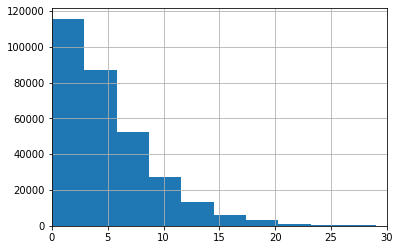

In [19]:
df.groupby('sk_id_curr').count().sk_id_bureau.hist(bins=40)
plt.xlim(0,30)

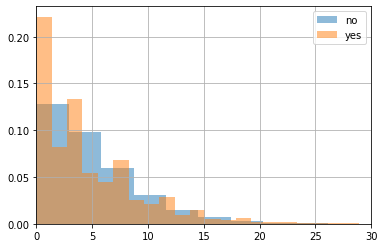

In [27]:
df.query('target == 0').groupby('sk_id_curr').count().sk_id_bureau\
    .hist(bins=40, alpha=0.5, density=True, label='no')
df.query('target == 1').groupby('sk_id_curr').count().sk_id_bureau\
    .hist(bins=40, alpha=0.5, density=True, label='yes')
plt.xlim(0,30)
plt.legend()

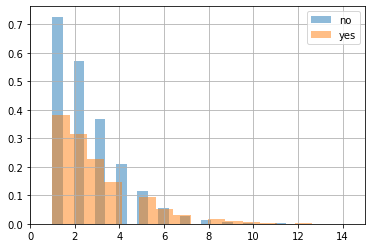

In [30]:
df.query('(target == 0) & (credit_active == "active")').groupby('sk_id_curr').count().sk_id_bureau\
    .hist(bins=40, alpha=0.5, density=True, label='no')
df.query('(target == 1) & (credit_active == "active")').groupby('sk_id_curr').count().sk_id_bureau\
    .hist(bins=40, alpha=0.5, density=True, label='yes')
plt.xlim(0,15)
plt.legend()

<AxesSubplot:>

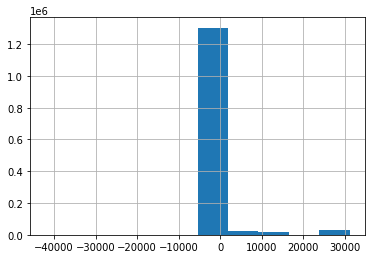

In [32]:
df.days_credit_enddate.hist()

# OLD

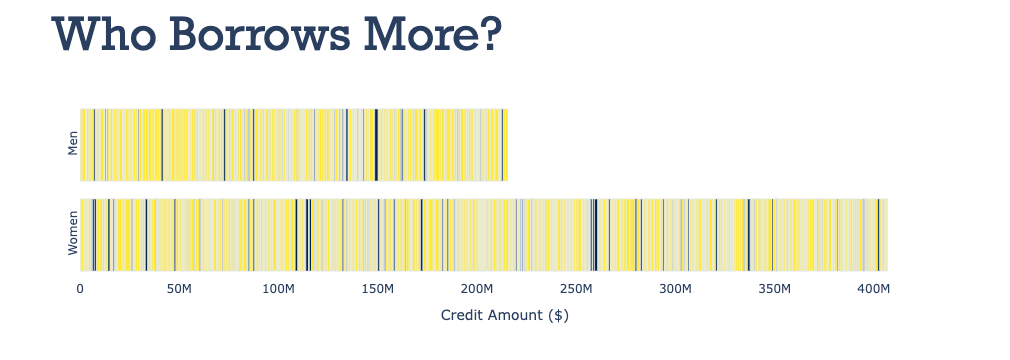

In [13]:
df = data_io['applications'].sample(1000)
fig = px.bar(df, y="code_gender", x="amt_credit", color='target',
             title='Who Borrows More?',
            labels=dict(amt_credit="Credit Amount ($)"),
            color_continuous_scale=px.colors.sequential.Cividis_r,
            color_discrete_map={'no default':'#ffcc33',
                                'default':'#f7f6f1'})

fig.update_layout(
        title_font_family="Rockwell",
        title_font_size=45,
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell",
        ),
        yaxis = dict(
                tickmode = 'array',
                tickvals = [0,1],
                ticktext = ['Women', 'Men'],
                title=''
            ))
fig.update_yaxes(visible=True, showticklabels=True, tickangle=270)
fig.update_coloraxes(showscale=False)

PlotMng.save_plot(fig, '0_barh_gender_credit_amount.html')
fig

# Age

In [32]:
data_io['applications']['age'] = - data_io['applications'].days_birth / 365


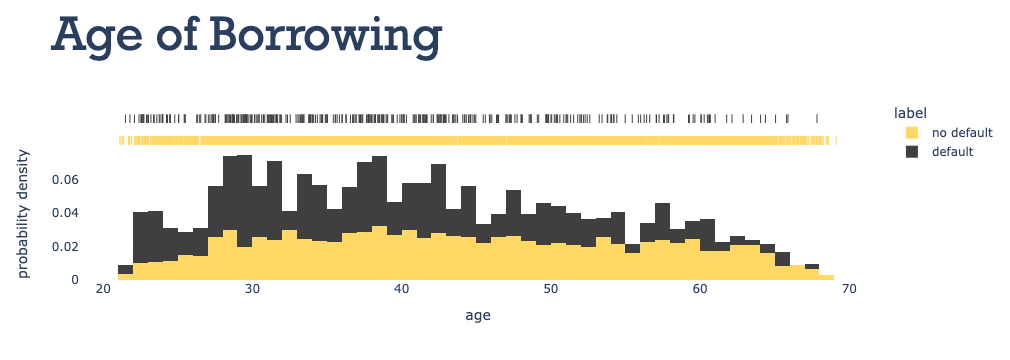

In [33]:
df = data_io['applications'].sample(4000)
fig = px.histogram(df, x="age", color="label", marginal="rug", nbins=60,
                   histnorm='probability density',
                  title='Age of Borrowing', color_discrete_map={'no default':'#ffcc33',
                                'default':'#000'})

fig.update_layout(
        title_font_family="Rockwell",
        title_font_size=45,
        hoverlabel=dict(
            bgcolor="white",
            font_size=16,
            font_family="Rockwell",
        ))
fig.update_traces(opacity=0.75)

PlotMng.save_plot(fig, '1_age.html')
fig

## Bureau

In [54]:
bureau_agg = bureau.groupby('sk_id_curr').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['buro_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

In [55]:
# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['credit_active_active'] == 1]
active_agg = active.groupby('sk_id_curr').agg(num_aggregations)
active_agg.columns = pd.Index(['active_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='sk_id_curr')
del active, active_agg
gc.collect()

0

In [56]:
# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['credit_active_closed'] == 1]
closed_agg = closed.groupby('sk_id_curr').agg(num_aggregations)
closed_agg.columns = pd.Index(['closed_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='sk_id_curr')
del closed, closed_agg, bureau
gc.collect()

0

In [57]:
bureau_agg

,buro_days_credit_MIN,buro_days_credit_MAX,buro_days_credit_MEAN,buro_days_credit_VAR,buro_days_credit_enddate_MIN,buro_days_credit_enddate_MAX,buro_days_credit_enddate_MEAN,buro_days_credit_update_MEAN,buro_credit_day_overdue_MAX,buro_credit_day_overdue_MEAN,...,closed_amt_credit_sum_overdue_MEAN,closed_amt_credit_sum_limit_MEAN,closed_amt_credit_sum_limit_SUM,closed_amt_annuity_MAX,closed_amt_annuity_MEAN,closed_cnt_credit_prolong_SUM,closed_months_balance_min_MIN,closed_months_balance_max_MAX,closed_months_balance_size_MEAN,closed_months_balance_size_SUM
sk_id_curr,,,,,,,,,,,,,,,,,,,,,
100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,-93.142857,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-51.0,0.0,35.000000,140.0
100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,-499.875000,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,0.0,15.000000,90.0
100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,-816.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,-532.000000,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,-54.333333,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,13.000000,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456249,-2713,-483,-1667.076923,407302.243590,-2499.0,1363.0,-1232.333333,-1064.538462,0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
456250,-1002,-760,-862.000000,15724.000000,-272.0,2340.0,1288.333333,-60.333333,0,0.0,...,0.0,0.0,0.0,384147.0,384147.0,0.0,-32.0,0.0,33.000000,33.0
456253,-919,-713,-867.500000,10609.000000,-189.0,1113.0,280.500000,-253.250000,0,0.0,...,0.0,0.0,0.0,58369.5,58369.5,0.0,-30.0,0.0,31.000000,62.0


In [ ]:
class BureauFeatures:
    
    BIN_FEATURES = ['code_gender', 'flag_own_car', 'flag_own_realty']
    REQUIRED_DATASETS = ['bureau', 'bureau_balance']
    
    num_aggregations = {
        'days_credit': ['min', 'max', 'mean', 'var'],
        'days_credit_enddate': ['min', 'max', 'mean'],
        'days_credit_update': ['mean'],
        'credit_day_overdue': ['max', 'mean'],
        'amt_credit_max_overdue': ['mean'],
        'amt_credit_sum': ['max', 'mean', 'sum'],
        'amt_credit_sum_debt': ['max', 'mean', 'sum'],
        'amt_credit_sum_overdue': ['mean'],
        'amt_credit_sum_limit': ['mean', 'sum'],
        'amt_annuity': ['max', 'mean'],
        'cnt_credit_prolong': ['sum'],
        'months_balance_min': ['min'],
        'months_balance_max': ['max'],
        'months_balance_size': ['mean', 'sum']
    }
    
    def __init__(self, data_io):
        self.data_io = data_io
    
    def preprocess(self) -> tuple
        encoder1 = OneHotEncoderWithMemory(nan_category=False)
        bureau = encoder1.fit_transform(self.data_io['bureau'])
        self.bureau_cat_ = encoder1.encoded_columns_

        encoder2 = OneHotEncoderWithMemory(nan_category=False)
        bb = encoder2.fit_transform(self.data_io['bureau_balance'])
        self.bb_cat_ = encoder2.encoded_columns_
        
        return bureau, bb
    
    def aggregate(bureau, bb):
        # Bureau balance: Perform aggregations and merge with bureau.csv
        bb_aggregations = {'months_balance': ['min', 'max', 'size']}
        for col in bb_cat:
            bb_aggregations[col] = ['mean']
        bb_agg = bb.groupby('sk_id_bureau').agg(bb_aggregations)
        bb_agg.columns = pd.Index([e[0] + "_" + e[1].lower() for e in bb_agg.columns.tolist()])
        bureau = bureau.join(bb_agg, how='left', on='sk_id_bureau')
        bureau.drop(['sk_id_bureau'], axis=1, inplace= True)
        
        del bb, bb_agg
        gc.collect()
        
        # Bureau and bureau_balance categorical features
        cat_aggregations = {}
        for cat in self.bureau_cat_: cat_aggregations[cat] = ['mean']
        for cat in self.bb_cat_: cat_aggregations[cat + "_mean"] = ['mean']
        
        bureau_agg = bureau.groupby('sk_id_curr').agg({**self.num_aggregations, **self.cat_aggregations})
        bureau_agg.columns = pd.Index(['buro_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
        
        # Bureau: Active credits - using only numerical aggregations
        active = bureau[bureau['credit_active_active'] == 1]
        active_agg = active.groupby('sk_id_curr').agg(num_aggregations)
        active_agg.columns = pd.Index(['active_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(active_agg, how='left', on='sk_id_curr')
        del active, active_agg
        gc.collect()
        
        # Bureau: Closed credits - using only numerical aggregations
        closed = bureau[bureau['credit_active_closed'] == 1]
        closed_agg = closed.groupby('sk_id_curr').agg(num_aggregations)
        closed_agg.columns = pd.Index(['closed_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
        bureau_agg = bureau_agg.join(closed_agg, how='left', on='sk_id_curr')
        del closed, closed_agg, bureau
        gc.collect()
        
        return bureau
    
    @staticmethod
    def add_new_features(df):
         # Some simple new features (percentages)
        df['days_employed_perc'] = df['days_employed'] / df['days_birth']
        df['income_credit_perc'] = df['amt_income_total'] / df['amt_credit']
        df['income_per_person'] = df['amt_income_total'] / df['cnt_fam_members']
        df['annuity_income_perc'] = df['amt_annuity'] / df['amt_income_total']
        df['payment_rate'] = df['amt_annuity'] / df['amt_credit']
        return df
    
    def generate_features(self):
        assert set(REQUIRED_DATASETS).issubset(set(self.data_io.list_loaded()))
        bureau, bb = self.preprocess(df)
        bureau = self.aggregate(bureau, bb)
        
        
        gc.collect()
        self.dataset = df
        
        return df

# Data Pipeline

`DatasetsFilename` - enum class to specify path for each filename

`DataIO` - Loading datasets by name. **Input**: falename (str), **output**: dict[pd.DataFrame]
* from file (parquet)
* from S3
* from SQL (S3 - Athena)

`DataAggregators` - **Input**: DataIO instance, **output**: single pd.DataFrame
`TrainingData` - **Input**: TargetDataAggregator, List[FeatureDataAggregator], **output**: single dataset
`Transformer`: **input**: pd.DataFrame, **output**: pd.DataFrame